In [109]:
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('/Users/balbi/Downloads/pyMorfologik-master'))
if module_path not in sys.path:
    sys.path.append(module_path)
from pymorfologik import Morfologik
from pymorfologik.parsing import ListParser
import numpy as np
from __future__ import print_function
import string
from multiprocessing import cpu_count, Pool
import dask.dataframe as dd
from dask.multiprocessing import get
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def lemmatisation(text):
    parser = ListParser()
    stemmer = Morfologik()
    stemming = stemmer.stem([text], parser)
    words_list = list()
    for s in stemming:
        for i in s:
            for l in i:
                if(len(l) > 1):
                    words_list.append(l)
    return words_list

In [3]:
emotions = pd.read_csv('emotionsTable.csv')

In [4]:
def detectingEmotionsInText(text):
    words_list = lemmatisation(text)
    numberOfWords = len(words_list)
    result = 0
    if(numberOfWords > 0):
        emotionsCounter = 0
        words = pd.DataFrame()
        words = words.reset_index()  
        for el in words_list: 
            data = emotions[emotions['word'] == el]
            words = words.append(data)      
        emotionsCounter = words['sentiment'].sum()
        result = emotionsCounter/numberOfWords
    return result

In [5]:
def getEmotionStatusOfText(result):
    if(result =< 0):
        return 'negative'
    elif(result > 0):
        return 'positive'

In [ ]:
result = detectingEmotionsInText('Uważam że zmuszanie dzieci do jedzenia warzyw jest karygodne oraz bestialskie')
print(getEmotionStatusOfText(result))

In [ ]:
comments = pd.read_csv('oceny.csv')
numberOfComments = len(comments)
mean = comments['Ocena'].mean()

In [ ]:
%%time
comments_list = comments["Komentarz"].values
counter = 0
newCommentsTable = pd.DataFrame()
for comment in comments_list:
    test = detectingEmotionsInText(comment)
    newCommentsTable = newCommentsTable.append({'detectingEmotions': lemmatisation(comment), 'counter': test, 'result': getEmotionStatusOfText(test)}, ignore_index=True)

In [ ]:
table = comments.join(newCommentsTable)
#table.to_csv('FilmWeb-detectingEmotions.csv', encoding='utf-8', index=False)

In [77]:
def prepereDataWithoutLemmatisation(maximumNegativeRate, mimimumPositiveRate, ):
    comments = pd.read_csv('FilmWeb-commentsRates.csv')
    comments.loc[comments.emotion == 'neutral', 'emotion'] = "negative"
    comments = comments[(comments.rate <= maximumNegativeRate) | (comments.rate >= mimimumPositiveRate)]
    comments = comments.reset_index()
    charToRemove= dict.fromkeys('!@#$?.:,')
    result_df['Text'] = result_df['Text'].translate(charToRemove)
    return comments

In [75]:
prepereDataWithoutLemmatisation(1,10)

,index,Text,emotion,rate
0,3,"""Boże, zaraz się zrzygam"".. ...",negative,1
1,7,"Film dla ""ajfonowych"" lemingów z ujemnym IQ. ...",negative,1
2,10,To najbardziej antyfeministyczna rzecz w dziej...,negative,1
3,11,Prawdziwy dramat Na wst...,negative,1
4,14,Film Za mało Złotych M...,negative,1
5,15,Hmm... budżet: 40 000 000 $ ...,negative,1
6,18,Połączenie komedii romantycznej z soft porno. ...,negative,1
7,20,Chciałabym odzobaczyć f...,negative,1
8,27,"""Boże, zaraz się zrzygam""..Słowa Koroniewskiej...",negative,1
9,31,"Film dla ""ajfonowych"" lemingów z ujemnym IQ.Te...",negative,1


In [ ]:
%%time
data = prepereDataWithoutLemmatisation()
print ('dataset: ' + str(len(data)) + ' objects')
newCommentsTable = pd.DataFrame()
for index, comment in data.iterrows():
    text = ' '.join(comment['Text'].split())
    number = detectingEmotionsInText(text)
    emotion = getEmotionStatusOfText(number)
    newCommentsTable = newCommentsTable.append({"text": comment['Text'], "detectingEmotion": emotion, 'emotion': comment['emotion']}, ignore_index=True)

In [76]:
%%time
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

def calculateOneRow(index, text, emotion, rate):
    print(text)
    text = ' '.join(text.split())
    number = detectingEmotionsInText(text)
    result_emotion = getEmotionStatusOfText(number)
    return {"text": text, "detectingEmotion": result_emotion, 'emotion': emotion}

def parallelize(data, func):
    print (partitions)
    data_split = np.array_split(data, partitions)
    pool = Pool(cores)
    mapResult = pool.map(func, data_split)
    data = pd.concat(mapResult)
    pool.close()
    pool.join()
    return data

cores = cpu_count()
partitions = cores

data = prepereDataWithoutLemmatisation(1,10)
ddata = dd.from_pandas(data, npartitions=partitions)


result = ddata.map_partitions(lambda df: df.apply((lambda row: calculateOneRow(*row)), axis=1)).compute(get=get)
result_df = pd.DataFrame()
for o in result:
    result_df = result_df.append(o, ignore_index=True)

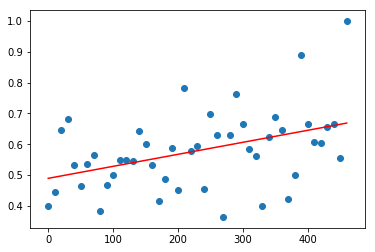

In [113]:
def get_length(text):
    return len(text)

def get_length_bin(length):
    return length / 10

def get_score(result):
    return 1 if result else 0

result_df.loc[result_df.detectingEmotion == 'neutral', 'detectingEmotion'] = "negative"
result_df['correct_guess'] = result_df['detectingEmotion'] == result_df['emotion']
result_df['score'] = map(get_score, result_df['correct_guess'])
result_df['text_length'] = map(get_length, result_df['text'])
result_df['text_length_bin'] = map(get_length_bin, result_df['text_length'])
grouped = result_df.groupby('text_length_bin', as_index=False)['score'].mean()

fig, ax = plt.subplots()
x = grouped.text_length_bin * 10
y = grouped.score
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y)

fig.show()

In [ ]:
table